In [21]:
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import sunpy
import math
import numpy as np
from sunpy.coordinates.sun import carrington_rotation_number
from scipy.spatial import distance
import glob
from generations import *
from plot import *
from em import *
import warnings
warnings.filterwarnings('ignore')
import uuid

## Greenwich

In [8]:
dfs = []
for fin in glob.glob('data/greenwich/*.txt'):
    dfs.append(pd.read_csv(fin, header = None))
greenwich = pd.concat(dfs)

In [9]:
def is_float(element: any) -> bool:
    #If you expect None to be passed:
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False
    
greenwich["year"] = greenwich[0].str.slice(stop = 4).astype(int)
greenwich["month"] = greenwich[0].str.slice(start = 4, stop = 6).astype(int)
greenwich["day"] = greenwich[0].str.slice(start = 6, stop = 8).astype(int)
greenwich["Greenwich sunspot group"] = greenwich[0].str.slice(start = 12, stop = 20).apply(lambda x: int(x) 
    if (x.replace(" ","").isnumeric()) else None)
greenwich["CLongtitude"] = greenwich[0].str.slice(start = 57, stop = 62).apply(lambda x: float(x) 
    if is_float(x.replace(" ","")) else None).astype(float)
greenwich["Latitude"] = greenwich[0].str.slice(start = 63, stop = 68).apply(lambda x: float(x) 
    if is_float(x.replace(" ","")) else None).astype(float)
greenwich["Date"] = pd.to_datetime(greenwich[0].str.slice(stop = 4) + "-" + greenwich["month"].astype(str) + "-" + greenwich["day"].astype(str))
greenwich["CR"] = carrington_rotation_number(greenwich.loc[:, "Date"])
greenwich = greenwich.dropna().reset_index(drop=True)

## Zurich

In [10]:
dig = pd.read_csv("data/Digitized_1916-1920.csv")

In [11]:
dig = dig.loc[dig["Object"] == 'Sunspot']
dig['Date'] = pd.to_datetime(dig['Date'])
dig["CR"] = carrington_rotation_number(dig.loc[:, "Date"])

In [12]:
cr = 849
sunspots = dig.loc[(dig["CR"] > cr) & (dig["CR"] < cr + 1)].dropna()
f = lambda x: (x.Column_6 - (68.70553089 - 0.08209453 * (x.Date -  pd.to_datetime("1880-01-01")).days)) % 360
sunspots.Column_6 = sunspots.apply(f, axis=1)

greenwich_centers = greenwich.loc[(greenwich["CR"] > cr) & (greenwich["CR"] < cr + 1) &(greenwich["Greenwich sunspot group"] < 10000)].dropna()
centers = []
for group in greenwich_centers.groupby(by="Greenwich sunspot group"):
    x = group[1].CLongtitude.mean()
    y = group[1].Latitude.mean()
    centers.append([x,y])

centers = np.array(centers)
data = sunspots.loc[:, ["Column_6", "Column_4"]].to_numpy()

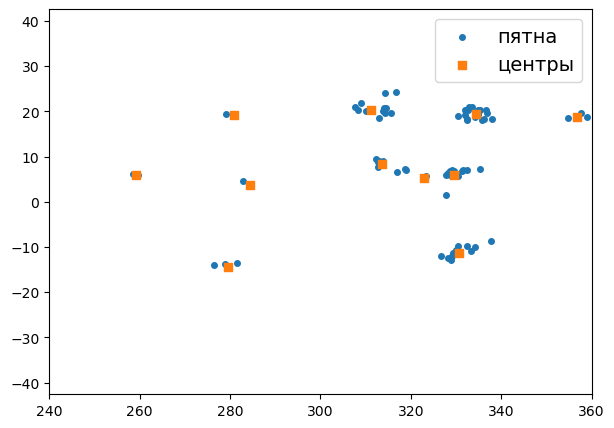

In [13]:
a, b = 240, 360
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
#plt.title(f"ll = {round(gm.best_attempt['ll'],2)}")
plt.scatter(data[:, 0], data[:, 1], s=16, label="пятна")
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label="центры")
axs.set_aspect(1)
plt.legend(fontsize=14)
plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"before_{uuid.uuid4()}.png", dpi=150) 

In [16]:
groups = len(centers)
gm = multiEM(n_components=groups,  max_iter=200, reg_covar=1e-6, eps=1e-270)
gm.fit(data, covariances=[[[0.25, 0],[0, 0.25]], [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, 0], [0, 6]]], fixed_means=centers, n_init=10)

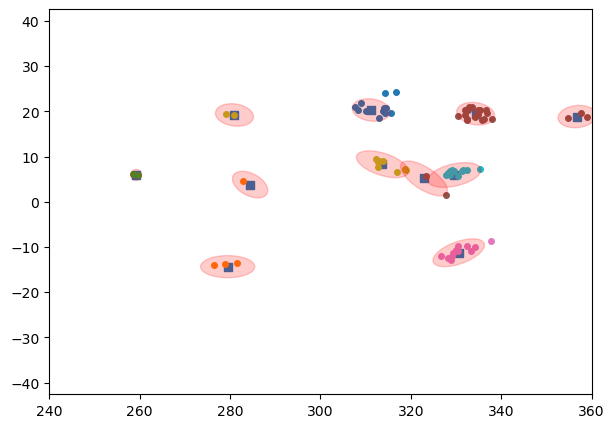

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], marker='s')

for i in range(groups):
    group = data[np.array(gm.predict()[0]) == i]
    plt.scatter(group[:, 0], group[:, 1], s = 16)

    typeCov = np.argmax(gm.cov_weights_[i])
    cov = rotate_matrix(gm.covariances_[typeCov], gm.phi[i, typeCov])
    plot_cov_ellipse(gm.means_[i],cov, alpha=0.2, color='red')

plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"after_{uuid.uuid4()}.png", dpi=150) 

In [18]:
cr = 848
sunspots = dig.loc[(dig["CR"] > cr) & (dig["CR"] < cr + 1)].dropna()
f = lambda x: (x.Column_6 - (68.70553089 - 0.08209453 * (x.Date -  pd.to_datetime("1880-01-01")).days)) % 360
sunspots.Column_6 = sunspots.apply(f, axis=1)

greenwich_centers = greenwich.loc[(greenwich["CR"] > cr) & (greenwich["CR"] < cr + 1) &(greenwich["Greenwich sunspot group"] < 10000)].dropna()
centers = []
for group in greenwich_centers.groupby(by="Greenwich sunspot group"):
    x = group[1].CLongtitude.mean()
    y = group[1].Latitude.mean()
    centers.append([x,y])

centers = np.array(centers)
data = sunspots.loc[:, ["Column_6", "Column_4"]].to_numpy()

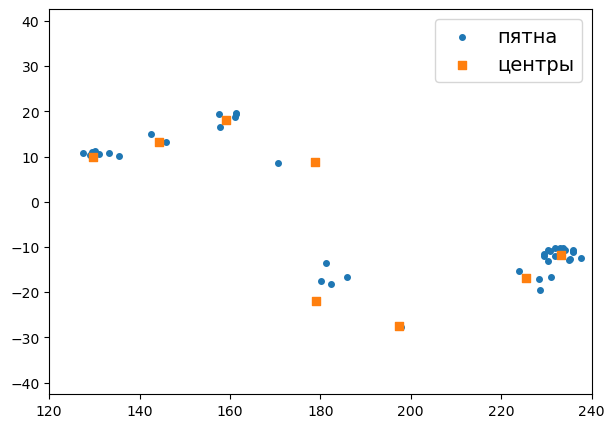

In [19]:
a, b = 120, 240
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(data[:, 0], data[:, 1], s=16, label="пятна")
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label="центры")
axs.set_aspect(1)
plt.legend(fontsize=14)
plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"before_{uuid.uuid4()}.png", dpi=150) 

In [20]:
groups = len(centers)
gm = multiEM(n_components=groups,  max_iter=200, reg_covar=1e-6, eps=1e-270)
gm.fit(data, covariances=[[[0.25, 0],[0, 0.25]], [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, 0], [0, 6]]], fixed_means=centers, verbose=2, n_init=10)

run 0 ll = -2554.093010947983
run 1 ll = -2550.5650284809403
run 2 ll = -2583.3699964330353
run 3 ll = -2586.6572783542
run 4 ll = -2585.9238831136577
run 5 ll = -2539.2659056917705
run 6 ll = -2531.6301146536434
run 7 ll = -2543.379215491274
run 8 ll = -2585.564884451927
run 9 ll = -2546.083210557992


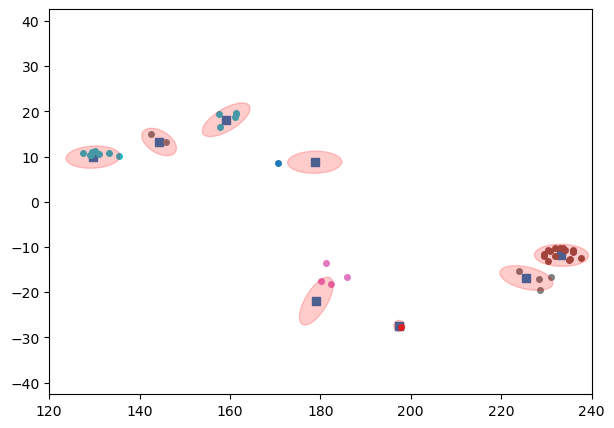

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], marker='s')

for i in range(groups):
    group = data[np.array(gm.predict()[0]) == i]
    plt.scatter(group[:, 0], group[:, 1], s = 16)

    typeCov = np.argmax(gm.cov_weights_[i])
    cov = rotate_matrix(gm.covariances_[typeCov], gm.phi[i, typeCov])
    plot_cov_ellipse(gm.means_[i],cov, alpha=0.2, color='red')

plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"after_{uuid.uuid4()}.png", dpi=150) 

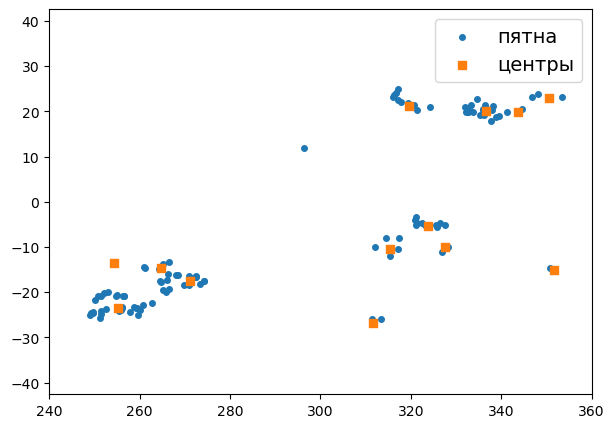

In [22]:
a, b = 240, 360
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(data[:, 0], data[:, 1], s=16, label="пятна")
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label="центры")
axs.set_aspect(1)
plt.legend(fontsize=14)
plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"before_{uuid.uuid4()}.png", dpi=150) 

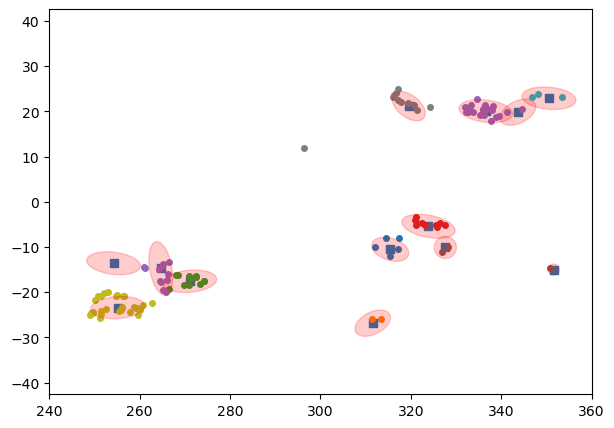

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], marker='s')

for i in range(groups):
    group = data[np.array(gm.predict()[0]) == i]
    plt.scatter(group[:, 0], group[:, 1], s = 16)

    typeCov = np.argmax(gm.cov_weights_[i])
    cov = rotate_matrix(gm.covariances_[typeCov], gm.phi[i, typeCov])
    plot_cov_ellipse(gm.means_[i],cov, alpha=0.2, color='red')

plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"after_{uuid.uuid4()}.png", dpi=150) 

In [24]:
cr = 847
sunspots = dig.loc[(dig["CR"] > cr) & (dig["CR"] < cr + 1)].dropna()
f = lambda x: (x.Column_6 - (68.70553089 - 0.08209453 * (x.Date -  pd.to_datetime("1880-01-01")).days)) % 360
sunspots.Column_6 = sunspots.apply(f, axis=1)

greenwich_centers = greenwich.loc[(greenwich["CR"] > cr) & (greenwich["CR"] < cr + 1) &(greenwich["Greenwich sunspot group"] < 10000)].dropna()
centers = []
for group in greenwich_centers.groupby(by="Greenwich sunspot group"):
    x = group[1].CLongtitude.mean()
    y = group[1].Latitude.mean()
    centers.append([x,y])

centers = np.array(centers)
data = sunspots.loc[:, ["Column_6", "Column_4"]].to_numpy()

In [25]:
groups = len(centers)
gm = multiEM(n_components=groups,  max_iter=200, reg_covar=1e-6, eps=1e-270)
gm.fit(data, covariances=[[[0.25, 0],[0, 0.25]], [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, 0], [0, 6]]], fixed_means=centers, verbose=2, n_init=10)

run 0 ll = -1834.4482305845631
run 1 ll = -1711.2930966760593
run 2 ll = -1716.0313424653398
run 3 ll = -1749.3763895023296
run 4 ll = -1711.672692001353
run 5 ll = -1698.5025372250984
run 6 ll = -1712.7076021718854
run 7 ll = -1712.9565336555027
run 8 ll = -1760.7683036189355
run 9 ll = -1718.788550486899


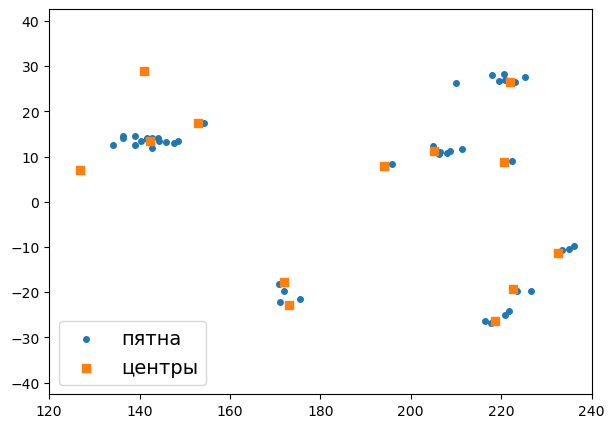

In [26]:
a, b = 120, 240
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(data[:, 0], data[:, 1], s=16, label="пятна")
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label="центры")
axs.set_aspect(1)
plt.legend(fontsize=14)
plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"before_{uuid.uuid4()}.png", dpi=150) 

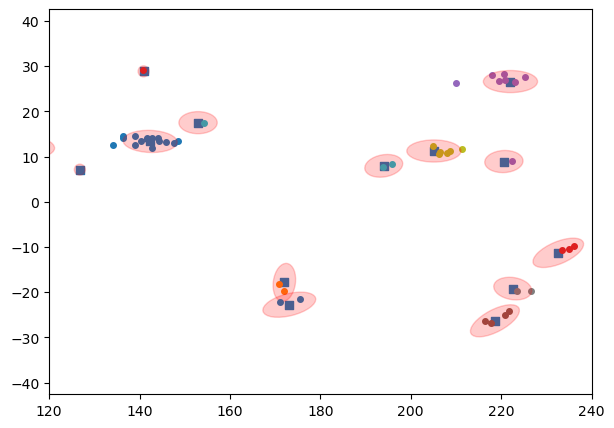

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], marker='s')

for i in range(groups):
    group = data[np.array(gm.predict()[0]) == i]
    plt.scatter(group[:, 0], group[:, 1], s = 16)

    typeCov = np.argmax(gm.cov_weights_[i])
    cov = rotate_matrix(gm.covariances_[typeCov], gm.phi[i, typeCov])
    plot_cov_ellipse(gm.means_[i],cov, alpha=0.2, color='red')

plt.axis("equal")
plt.xlim(a, b)
plt.ylim(-40, 40)
plt.savefig(f"after_{uuid.uuid4()}.png", dpi=150) 